In [1]:
!pip install -q requests beautifulsoup4
!pip install -qU langchain_community langchain langchain-google-genai chromadb langchain_huggingface langchain_chroma langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 47.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 53.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.6/441.6 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/

# Crawling data

In [2]:
from bs4 import BeautifulSoup, Tag
import requests
import hashlib
import pprint

# Global containers
full_contents = []
detailed_chunks = []

def get_doc_id(url):
    return hashlib.md5(url.encode("utf-8")).hexdigest()

def clean_html(article_soup: Tag):
    """Removes noisy elements from the provided article soup tag."""
    for tag in article_soup.find_all(['script', 'style', 'figure', 'img', 'table', 'div']):
        if not (tag.name == 'div' and tag.get('id') == 'ftwp-postcontent'):
            tag.decompose()
    return article_soup

def extract_text_between_tags(start_tag: Tag, end_tag: Tag = None):
    """Extracts all text content between a start tag and an end tag."""
    content = []
    for sibling in start_tag.find_next_siblings():
        if sibling == end_tag:
            break
        if sibling.name in ['p', 'ul', 'ol', 'li']:
            content.append(sibling.get_text(separator=' ', strip=True))
    return "\n".join(content)

def process_html_to_documents(url):
    """
    Processes a single article, correctly handling nested headings and headings that act only as containers.
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None, []

    soup = BeautifulSoup(response.text, "html.parser")
    main_article = soup.find(id="ftwp-postcontent")
    if not main_article:
        return None, []

    full_text = main_article.get_text(separator="\n", strip=True)
    full_doc = {
        "metadata": {"url": url, "doc_id": get_doc_id(url)},
        "text": full_text
    }

    clean_article = clean_html(main_article)
    headings = clean_article.find_all(['h2', 'h3', 'h4'])
    h1_tag = soup.find('h1')
    context_map = {"section_h1": h1_tag.get_text(strip=True) if h1_tag else "N/A"}

    chunks = []
    for i, current_heading in enumerate(headings):
        heading_level = current_heading.name
        heading_text = current_heading.get_text(strip=True)

        if heading_level == 'h2':
            context_map["section_h2"] = heading_text
            context_map.pop("section_h3", None)
            context_map.pop("section_h4", None)
        elif heading_level == 'h3':
            context_map["section_h3"] = heading_text
            context_map.pop("section_h4", None)
        elif heading_level == 'h4':
            context_map["section_h4"] = heading_text

        end_tag = headings[i + 1] if i + 1 < len(headings) else None
        content = extract_text_between_tags(current_heading, end_tag)

        if content.strip():
            # Sao chép context_map tại thời điểm này để tạo metadata
            metadata = context_map.copy()
            metadata["url"] = url
            metadata["doc_id"] = get_doc_id(url)
            chunks.append({
                "text": heading_text + ": " + content,
                "metadata": metadata
            })

    return full_doc, chunks


In [3]:
# main URL
source_url = "https://vnvc.vn/benh-thuong-gap-o-tre-em-duoi-5-tuoi/"

# Run
full_doc, chunks = process_html_to_documents(source_url)

if full_doc:
    full_contents.append(full_doc)
detailed_chunks.extend(chunks)

print("Content:")
print(full_contents[-1])
print("-" * 50)
pprint.pprint(f"Number of chunks: {len(detailed_chunks)}")
for doc in detailed_chunks[:4]:
    pprint.pprint(doc)
    print("-" * 50)


Content:
{'metadata': {'url': 'https://vnvc.vn/benh-thuong-gap-o-tre-em-duoi-5-tuoi/', 'doc_id': 'e0cc7f0cbbfeea7b3776d2bdd2d4329b'}, 'text': 'Những\nbệnh thường gặp ở trẻ em dưới 5 tuổi\nlà gì? Làm sao để phòng ngừa hiệu quả? Bài viết dưới đây sẽ liệt kê chi tiết 30+ bệnh lý thường gặp và cách phòng ngừa hiệu quả mà bố mẹ có thể tham khảo.\nTrẻ em là nhóm đối tượng dễ bị tổn thương do chức năng của hệ thống miễn dịch chưa hoàn thiện, sức đề kháng còn non nớt, chưa đủ khả năng bảo vệ trẻ chống lại các tác nhân gây bệnh, khiến trẻ dễ mắc bệnh. Đặc biệt, trẻ càng nhỏ, khi mắc bệnh càng nặng, nhất là nhóm trẻ em dưới 5 tuổi, khi mắc bệnh trẻ dễ biến chứng nguy hiểm và di chứng kéo dài, thậm chí đe dọa đến tính mạng.\nBS Trần Huỳnh Tấn - Quản lý Y khoa vùng 1 Hồ Chí Minh, Hệ thống\nTrung tâm tiêm chủng VNVC\ncho biết: “Với cơ thể nhỏ bé, sức đề kháng với bệnh tật non nớt, trẻ em dưới 5 tuổi luôn phải đối mặt với nguy cơ lây nhiễm và mắc nhiều loại bệnh khác nhau, nhất là các bệnh truyền nh

In [4]:
import requests
from bs4 import BeautifulSoup

url = "https://vnvc.vn/benh-thuong-gap-o-tre-em-duoi-5-tuoi/"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")
main_article = soup.find(id="ftwp-postcontent")

vnvc_links = main_article.find_all(
    "a",
    href=lambda x: x and x.startswith("https://vnvc.vn")
) if main_article else []

for link in vnvc_links:
    print(link["href"])

https://vnvc.vn/
https://vnvc.vn/mien-dich-thu-dong/
https://vnvc.vn/vac-xin-la-gi/
https://vnvc.vn/co-the-nguoi/he-mien-dich/
https://vnvc.vn/cam-lanh/
https://vnvc.vn/cum/
https://vnvc.vn/viem-phoi/
https://vnvc.vn/ho-ga-dau-hieu-va-trieu-chung-nhan-biet-benh/
https://vnvc.vn/tieu-chay-nguyen-nhan-trieu-chung-dieu-tri-va-cach-phong-ngua/
https://vnvc.vn/tieu-chay-cap-virus-rota-nguyen-nhan-trieu-chung-bien-chung-va-cach-phong-ngua/
https://vnvc.vn/benh-thuy-dau-nguyen-nhan-trieu-chung-va-cach-phong-benh-hieu-qua/
https://vnvc.vn/benh-tay-chan-mieng/
https://vnvc.vn/benh-soi-nguyen-nhan-trieu-chung-cach-phong-ngua-va-dieu-tri-hieu-qua/
https://vnvc.vn/sot-xuat-huyet/
https://vnvc.vn/benh-bach-hau-nguyen-nhan-trieu-chung-va-cach-chua-tri/
https://vnvc.vn/benh-zona-than-kinh/
https://vnvc.vn/rubella-soi-duc-nguyen-nhan-trieu-chung-bien-chung-va-cach-phong-ngua/
https://vnvc.vn/mun-coc-sinh-duc/
https://vnvc.vn/viem-nao-nhat-ban-nguyen-nhan-trieu-chung-dieu-tri-phong-ngua/
https://vnvc.v

In [5]:
for link in vnvc_links:
    
    full_doc, chunks = process_html_to_documents(link["href"])

    if full_doc:
        full_contents.append(full_doc)
    detailed_chunks.extend(chunks)
    
# Check output
print(f"Total content created: {len(full_contents)}\n")
print(f"Total chucnks created: {len(detailed_chunks)}\n")
for doc in detailed_chunks [:3]:
    pprint.pprint(doc)
    print("-" * 20)

Total content created: 23

Total chucnks created: 451

{'metadata': {'doc_id': 'e0cc7f0cbbfeea7b3776d2bdd2d4329b',
              'section_h1': '30+ bệnh thường gặp ở trẻ em dưới 5 tuổi và cách '
                            'phòng ngừa',
              'section_h2': 'Tầm quan trọng của phòng ngừa và điều trị bệnh ở '
                            'trẻ dưới 5 tuổi',
              'url': 'https://vnvc.vn/benh-thuong-gap-o-tre-em-duoi-5-tuoi/'},
 'text': 'Tầm quan trọng của phòng ngừa và điều trị bệnh ở trẻ dưới 5 tuổi: '
         'Trẻ em dưới 5 tuổi có hệ thống miễn dịch chưa hoàn chỉnh, khiến sự '
         'đề kháng với bệnh tật yếu hơn. Bên cạnh đó, miễn dịch thụ động nhận '
         'được từ mẹ trong thai kỳ và trong giai đoạn sơ sinh dần suy giảm và '
         '“cạn kiệt” khoảng 3 - 6 tháng sau sinh, khiến trẻ có nguy cơ rất cao '
         'mắc nhiều bệnh truyền nhiễm nguy hiểm.\n'
         'Năm 2020, ước tính có khoảng 5 triệu trẻ em dưới 5 tuổi tử vong, chủ '
         'yếu là do những 

In [6]:
import json
with open("detailed_chunks.json", "w", encoding="utf-8") as f:
    json.dump(detailed_chunks, f, ensure_ascii=False, indent=2)
print("Saved to detailed_chunks.json")

with open("full_contents.json", "w", encoding="utf-8") as f:
    json.dump(full_contents, f, ensure_ascii=False, indent=2)
print("Saved to full_contents.json")


Saved to detailed_chunks.json
Saved to full_contents.json


In [7]:
import json
import pprint

with open("/kaggle/input/healthdatavnvc/detailed_chunks.json", "r", encoding="utf-8") as f:
    detailed_chunks = json.load(f)
pprint.pprint(detailed_chunks[0])

print("-"*50)

with open("/kaggle/input/healthdatavnvc/full_contents.json", "r", encoding="utf-8") as f:
    full_contents = json.load(f)
pprint.pprint(full_contents[0])

{'metadata': {'doc_id': 'e0cc7f0cbbfeea7b3776d2bdd2d4329b',
              'section_h1': '30+ bệnh thường gặp ở trẻ em dưới 5 tuổi và cách '
                            'phòng ngừa',
              'section_h2': 'Tầm quan trọng của phòng ngừa và điều trị bệnh ở '
                            'trẻ dưới 5 tuổi',
              'url': 'https://vnvc.vn/benh-thuong-gap-o-tre-em-duoi-5-tuoi/'},
 'text': 'Tầm quan trọng của phòng ngừa và điều trị bệnh ở trẻ dưới 5 tuổi: '
         'Trẻ em dưới 5 tuổi có hệ thống miễn dịch chưa hoàn chỉnh, khiến sự '
         'đề kháng với bệnh tật yếu hơn. Bên cạnh đó, miễn dịch thụ động nhận '
         'được từ mẹ trong thai kỳ và trong giai đoạn sơ sinh dần suy giảm và '
         '“cạn kiệt” khoảng 3 - 6 tháng sau sinh, khiến trẻ có nguy cơ rất cao '
         'mắc nhiều bệnh truyền nhiễm nguy hiểm.\n'
         'Năm 2020, ước tính có khoảng 5 triệu trẻ em dưới 5 tuổi tử vong, chủ '
         'yếu là do những nguyên nhân có thể phòng ngừa được bằng vắc xin . '
   

# Multi-representation indexing

In [8]:
import os
from kaggle_secrets import UserSecretsClient
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document

os.environ["GOOGLE_API_KEY"] =  UserSecretsClient().get_secret("GOOGLE_API_KEY")
llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")


# Khởi tạo mô hình embedding
embedding_model = HuggingFaceEmbeddings(
    model_name="intfloat/multilingual-e5-base",
    encode_kwargs={"normalize_embeddings": True}
)

2025-07-20 02:09:38.746971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752977378.936853      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752977378.993185      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

modules.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

In [9]:
from langchain.chains.summarize import load_summarize_chain
from langchain.prompts import PromptTemplate
from langchain.docstore.document import Document

# Define custom summarization prompt
custom_prompt = PromptTemplate(
    input_variables=["text"],
    template=(
        "Bạn là một trợ lý y tế thông minh, có nhiệm vụ tóm tắt các bài viết về sức khỏe "
        "một cách tổng quan và đầy đủ để phục vụ cho quá trình tìm kiếm trở nên dễ dàng.\n\n"
        "Dưới đây là nội dung bài viết:\n{text}\n\n"
        "Tóm tắt:"
    )
)

# Load summarization chain using the custom prompt
summarizer = load_summarize_chain(llm, chain_type="stuff", prompt=custom_prompt)

# Run summarization
summaries = []
for doc in full_contents:
    if not doc: continue
    doc_obj = Document(page_content=doc["text"])
    summary = summarizer.run([doc_obj])
    summaries.append({
        "metadata": doc["metadata"],
        "summary": summary
    })


/tmp/ipykernel_36/3363641400.py:24: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  summary = summarizer.run([doc_obj])


In [10]:
print("Total summaries created:", len(summaries))
summaries[:3]

Total summaries created: 23


[{'metadata': {'url': 'https://vnvc.vn/benh-thuong-gap-o-tre-em-duoi-5-tuoi/',
   'doc_id': 'e0cc7f0cbbfeea7b3776d2bdd2d4329b'},
  'summary': 'Bài viết cung cấp thông tin chi tiết về các bệnh thường gặp ở trẻ em dưới 5 tuổi, nguyên nhân, triệu chứng và cách phòng ngừa hiệu quả.\n\n**Tóm tắt nội dung chính:**\n\n*   **Tầm quan trọng của phòng ngừa và điều trị:** Trẻ dưới 5 tuổi có hệ miễn dịch chưa hoàn thiện, dễ mắc bệnh và gặp biến chứng nguy hiểm. Phòng ngừa và điều trị sớm giúp bảo vệ sự phát triển toàn diện của trẻ.\n*   **Các bệnh thường gặp:**\n    *   **Hệ hô hấp:** Cảm lạnh, cúm, viêm mũi dị ứng, viêm phế quản, viêm thanh quản, viêm phổi, viêm xoang, hen suyễn, ho gà.\n    *   **Hệ tiêu hóa:** Trào ngược dạ dày thực quản, tiêu chảy (do virus Rota), táo bón, nhiễm giun.\n    *   **Nhiễm trùng:** Thủy đậu, tay chân miệng, sởi, sốt xuất huyết, bạch hầu, viêm tai giữa, nhiễm trùng đường tiết niệu, nhiễm trùng da.\n    *   **Bệnh ngoài da:** Zona thần kinh, Rubella, mụn cóc sinh dục

In [ ]:
from langchain_chroma import Chroma
from langchain_core.documents import Document

# Khởi tạo ChromaDB cho tóm tắt
chroma_summary = Chroma(
    collection_name="summaries",
    embedding_function=embedding_model,
    persist_directory="chroma_storage/summaries"
)
# chroma_summary.delete_collection()

# Lưu các summary vào ChromaDB
for item in summaries:
    chroma_summary.add_documents([
        Document(
            page_content=item["summary"],
            metadata=item["metadata"]
        )
    ])

In [ ]:
# Khởi tạo ChromaDB cho cách chunks
chroma_detail = Chroma(
    collection_name="detail_chunks",
    embedding_function=embedding_model,
    persist_directory="chroma_storage/details"
)
# chroma_detail.delete_collection()

# Lưu các summary vào ChromaDB
for item in detailed_chunks:
    chroma_detail.add_documents([
        Document(
            page_content=item["text"],
            metadata=item["metadata"]
        )
    ])


In [9]:
import shutil
import os

if os.path.exists("chroma_storage/details"):
    shutil.rmtree("chroma_storage/details")
if os.path.exists("chroma_storage/summaries"):
    shutil.rmtree("chroma_storage/summaries")

shutil.copytree("/kaggle/input/healthdatavnvc/chroma_storage/details", "chroma_storage/details")
shutil.copytree("/kaggle/input/healthdatavnvc/chroma_storage/summaries", "chroma_storage/summaries")

print("Đã sao chép")

Đã sao chép


In [10]:
from langchain_chroma import Chroma

chroma_summary = Chroma(
    collection_name="summaries",
    embedding_function=embedding_model,
    persist_directory="chroma_storage/summaries"    
)
chroma_detail = Chroma(
    collection_name="detail_chunks",
    embedding_function=embedding_model,
    persist_directory="chroma_storage/details"
)

# Query

## RAG-Fusion

In [11]:
from langchain.prompts import ChatPromptTemplate

template = """Bạn là một trợ lý ngôn ngữ AI giúp cải thiện kết quả tìm kiếm trong hệ thống truy xuất thông tin dựa trên vector.

Nhiệm vụ của bạn là viết lại câu hỏi gốc của người dùng thành 3 phiên bản khác nhau, có ý nghĩa tương đồng nhưng được diễn đạt theo nhiều cách khác nhau.  
Các câu hỏi viết lại này cần phản ánh sự đa dạng về cách diễn đạt, mức độ chi tiết hoặc các ý định tiềm ẩn khác nhau của người dùng, nhằm tăng khả năng tìm được tài liệu phù hợp khi sử dụng tìm kiếm theo độ tương đồng embedding.

Hãy trả về tổng cộng 4 câu hỏi: câu gốc và 3 câu viết lại, mỗi câu nằm trên một dòng riêng biệt, bắt đầu bằng câu hỏi gốc.

Câu hỏi gốc: {question}"""

prompt_rag_fusion = ChatPromptTemplate.from_template(template)


In [12]:
from langchain_core.output_parsers import StrOutputParser

generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [13]:
question = "Cách điều trị cảm lạnh"
generate_queries.invoke({"question": question})

['Cách điều trị cảm lạnh',
 'Phương pháp chữa trị bệnh cảm thông thường là gì?',
 'Tôi nên làm gì để nhanh khỏi bệnh cảm lạnh?',
 'Các biện pháp khắc phục tại nhà hiệu quả cho cảm lạnh là gì?']

# Retrieval

In [14]:
from langchain_core.runnables import RunnableLambda

def health_retriever(query):
    summary_docs = chroma_summary.similarity_search(query, k=3)
    
    doc_ids = list({doc.metadata["doc_id"] for doc in summary_docs})
    
    detail_docs = chroma_detail.similarity_search(
        query=query,
        k=5,
        filter={"doc_id": {"$in": doc_ids}}
    )
    return detail_docs
retriever = RunnableLambda(health_retriever)

# Hiển thị kết quả
query = "Cách điều trị cảm lạnh"
detail_docs = retriever.invoke(query)
for i, doc in enumerate(detail_docs, 1):
    print(f"Kết quả #{i}:")
    print(doc)
    print("-" * 80)

Kết quả #1:
page_content='5. Bị cảm lạnh nên uống gì?: Khi bị cảm lạnh, người bệnh nên uống những loại thực phẩm dinh dưỡng, chứa nhiều vitamin, khoáng chất,... giúp bổ sung cho cơ thể những dưỡng chất đẩy nhanh quá trình khỏi bệnh như mật ong, nước ép rau củ quả, nước dừa, nước lọc,...' metadata={'section_h1': 'Cảm lạnh là gì? Triệu chứng, nguyên nhân và cách chẩn đoán bệnh', 'section_h3': '5. Bị cảm lạnh nên uống gì?', 'url': 'https://vnvc.vn/cam-lanh/', 'doc_id': 'ae0ecfce51eb591fce01ebe71b69bd9d', 'section_h2': 'Cách điều trị cảm lạnh'}
--------------------------------------------------------------------------------
Kết quả #2:
page_content='Cách điều trị cảm lạnh ở trẻ sơ sinh và trẻ nhỏ: Để bé nghỉ ngơi nhiều nhất có thể trong không gian thoải mái, mặc quần áo thoáng mát. Cho trẻ uống nhiều nước. Đối với trẻ từ dưới 6 tháng tuổi trở lên, có thể cho trẻ bú sữa mẹ hoặc sữa công thức. Làm sách chất nhầy trong mũi của trẻ bằng cách sử dụng nước muối sinh lý nhỏ vào mũi trẻ trước khi 

In [15]:
from langchain.load import dumps, loads
from collections import defaultdict

def reciprocal_rank_fusion(results: list[list], k=60):
    """ Reciprocal_rank_fusion that takes multiple lists of ranked documents 
        and an optional parameter k used in the RRF formula """
    
    # Initialize a dictionary to hold fused scores for each unique document
    fused_scores = defaultdict(float)

    # Iterate through each list of ranked documents
    for docs in results:
        for rank, doc in enumerate(docs):
            doc_str = dumps(doc)
            # Update the score of the document using the RRF formula: 1 / (rank + k)
            fused_scores[doc_str] += 1 / (rank + k)

    reranked_results = [
        (loads(doc), score)
        for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
    ]

    return reranked_results

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion

In [17]:
import pprint

question = "Cách điều trị cảm lạnh"
docs = retrieval_chain_rag_fusion.invoke({"question": question})
print(len(docs))
pprint.pprint(docs[:10])

20
[(Document(id='6929a615-5c74-4b76-9afd-9c341f7bd0d3', metadata={'doc_id': 'ae0ecfce51eb591fce01ebe71b69bd9d', 'section_h3': '5. Bị cảm lạnh nên uống gì?', 'url': 'https://vnvc.vn/cam-lanh/', 'section_h1': 'Cảm lạnh là gì? Triệu chứng, nguyên nhân và cách chẩn đoán bệnh', 'section_h2': 'Cách điều trị cảm lạnh'}, page_content='5. Bị cảm lạnh nên uống gì?: Khi bị cảm lạnh, người bệnh nên uống những loại thực phẩm dinh dưỡng, chứa nhiều vitamin, khoáng chất,... giúp bổ sung cho cơ thể những dưỡng chất đẩy nhanh quá trình khỏi bệnh như mật ong, nước ép rau củ quả, nước dừa, nước lọc,...'),
  0.016666666666666666),
 (Document(id='257d8f6e-c46c-4177-81d8-4d341a17b8a8', metadata={'url': 'https://vnvc.vn/sot-xuat-huyet/', 'doc_id': 'b90402385758f7d031f7ff9e463bfada', 'section_h1': 'Sốt xuất huyết: Triệu chứng và nguyên nhân cảnh báo bệnh', 'section_h2': 'Điều trị bệnh sốt xuất huyết'}, page_content='Điều trị bệnh sốt xuất huyết: Hiện nay, sốt xuất huyết chưa có thuốc điều trị đặc hiệu, hầu h

In [18]:
from IPython.display import Markdown
from operator import itemgetter

# RAG
template = """Hãy trả lời câu hỏi một cách chi tiết, dễ hiểu, chính xác và trung thực dựa trên thông tin trong context dưới đây:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    {"context": retrieval_chain_rag_fusion, 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

question = "Cách điều trị cảm lạnh"
Markdown(final_rag_chain.invoke({"question":question}))

Có nhiều cách để điều trị cảm lạnh, bao gồm:

*   **Nghỉ ngơi:** Để cơ thể có thời gian phục hồi.
*   **Uống nhiều nước:** Bổ sung nước lọc, nước ép rau củ quả, nước dừa, mật ong,... để bù nước và các chất dinh dưỡng cần thiết.
*   **Ăn thức ăn dễ tiêu:** Chọn các loại thực phẩm giàu dinh dưỡng, dễ ăn, dễ nuốt và dễ tiêu hóa như cháo, súp, canh hầm.
*   **Xịt thông mũi:** Người lớn có thể dùng thuốc xịt hoặc nhỏ mũi trong tối đa 5 ngày. Trẻ em trên 6 tuổi cần có chỉ định của bác sĩ. Không dùng cho trẻ dưới 6 tuổi.
*   **Vệ sinh mũi họng:** Sử dụng nước muối loãng để vệ sinh họng và mũi giúp giảm viêm nhiễm.
*   **Đối với trẻ sơ sinh và trẻ nhỏ:**
    *   Cho trẻ bú sữa mẹ hoặc sữa công thức (với trẻ dưới 6 tháng).
    *   Làm sạch chất nhầy trong mũi bằng nước muối sinh lý và dụng cụ hút mũi.
    *   Thoa vaseline quanh viền lỗ mũi để giảm kích ứng.
    *   Sử dụng máy tạo độ ẩm trong phòng.
    *   Mật ong có thể giúp giảm ho cho trẻ trên 12 tháng tuổi (dùng trước khi ngủ).
*   **Kiêng cữ:**
    *   Hạn chế hút thuốc và tránh khói thuốc.
    *   Không dùng kháng sinh (vì cảm lạnh do virus).
    *   Không dùng chất kích thích như rượu, bia, caffeine.
    *   Hạn chế thực phẩm giàu protein, chất béo, đồ chế biến sẵn, đồ ăn nhiều gia vị mặn, nước ngọt có ga.

# Chatbot

In [19]:
from langchain.tools import StructuredTool
from pydantic import BaseModel

class RagInput(BaseModel):
    question: str

def run_final_rag(question: str):
    return retrieval_chain_rag_fusion.invoke({"question": question})

final_rag_tool = StructuredTool.from_function(
    name="final_rag_tool",
    description="Truy vấn thông tin y tế bằng RAG",
    func=run_final_rag,
    args_schema=RagInput
)


In [20]:
from langgraph.prebuilt import create_react_agent

tools = [final_rag_tool]
health_chatbot = create_react_agent(llm, tools)

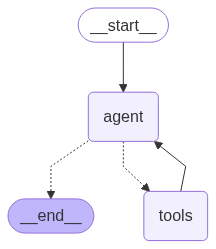

In [21]:
from IPython.display import Image, display

display(Image(health_chatbot.get_graph().draw_mermaid_png()))

In [22]:
from langchain_core.messages import HumanMessage, SystemMessage

def query_llm(prompt: str) -> str:
    """Helper for sending a user message to the model with a system prompt."""
    system_prompt = (
        "Bạn là một trợ lý thông minh trong lĩnh vực y tế, được huấn luyện để hỗ trợ người dùng bằng tiếng Việt một cách dễ hiểu, chi tiết và đáng tin cậy.\n\n"
        "Nhiệm vụ của bạn:\n"
        "- Nếu người dùng đặt câu hỏi xã giao hoặc đơn giản (ví dụ: 'Chào bạn', 'Bạn khỏe không?'), hãy phản hồi một cách thân thiện mà không cần sử dụng thêm công cụ.\n"
        "- Nếu câu hỏi liên quan đến thông tin chuyên môn y tế (chẩn đoán, điều trị, triệu chứng, thuốc, v.v.), bạn **bắt buộc phải sử dụng công cụ truy xuất thông tin (RAG)** để tìm kiếm và tổng hợp câu trả lời.\n"
        "- Nếu sau khi truy xuất mà **không có đủ thông tin tin cậy**, bạn cần thông báo rõ ràng rằng chưa có dữ liệu phù hợp, **không được tự suy diễn hoặc phỏng đoán**.\n\n"
        "Yêu cầu bắt buộc:\n"
        "- Trả lời hoàn toàn bằng tiếng Việt.\n"
        "- Trình bày câu trả lời một cách dễ hiểu, khoa học và có cấu trúc rõ ràng.\n"
        "- Tránh đưa ra lời khuyên y tế không có cơ sở hoặc không rõ nguồn gốc.\n"
        "- Không được trả lời các câu hỏi ngoài phạm vi y tế chuyên môn.\n"
        "- Luôn ưu tiên sự an toàn, độ chính xác và tính minh bạch của thông tin y khoa."
        "- Luôn trích nguồn link của câu trả lời"
    )

    response = health_chatbot.invoke(
        {
            "messages": [
                SystemMessage(content=system_prompt),
                HumanMessage(content=prompt),
            ]
        }
    )

    # return response
    return response["messages"][-1].content

In [23]:
query_llm("Bệnh nào là bệnh truyền nhiễm thường gặp ở trẻ em dưới 5 tuổi do virus tấn công đường hô hấp trên?")

'Bệnh truyền nhiễm thường gặp ở trẻ em dưới 5 tuổi do virus tấn công đường hô hấp trên là bệnh cúm. Cúm là bệnh nhiễm trùng đường hô hấp do virus cúm (Influenza virus) gây ra. Trẻ em là đối tượng dễ mắc cúm với tỷ lệ mắc bệnh cao hơn so với người lớn.\n\n**Một số thông tin khác về bệnh cúm:**\n\n*   **Tỷ lệ mắc bệnh:** Theo thống kê của WHO, thế giới có khoảng 5-10% người lớn và 20-30% trẻ em nhiễm cúm mỗi năm.\n*   **Biến chứng:** Bệnh cúm có thể tự khỏi nhưng cũng có khả năng gây ra những biến chứng nghiêm trọng ở trẻ nhỏ dưới 5 tuổi như viêm tai, viêm phế quản, viêm phổi, viêm não, thậm chí có thể dẫn đến tử vong.\n\n**Nguồn:**\n\n*   [https://vnvc.vn/cum/](https://vnvc.vn/cum/)'

In [24]:
# Khi trả lời thông tin không có trong database
query_llm("Bệnh covid 19 là gì")

'Hiện tại, tôi không có đủ thông tin tin cậy để trả lời chính xác câu hỏi của bạn về bệnh COVID-19.'

# Validation

In [25]:
!pip -q install ragas
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you hav

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 4.2 MB/s eta 0:00:00


In [26]:
import json
import pprint

with open("/kaggle/input/healthqa/health_qa.js", "r", encoding="utf-8") as f:
    qa_data = json.load(f)
pprint.pprint(qa_data[0])

{'qa_pairs': [{'answer': 'Cảm lạnh là bệnh lý truyền nhiễm do virus tấn công '
                         'và gây nhiễm trùng đường hô hấp trên (mũi, họng và '
                         'xoang) thường gặp ở trẻ em dưới 5 tuổi.',
               'question': 'Bệnh nào là bệnh truyền nhiễm thường gặp ở trẻ em '
                           'dưới 5 tuổi do virus tấn công đường hô hấp trên?'},
              {'answer': 'Cúm là bệnh “siêu lây nhiễm" thường gặp ở trẻ em '
                         'dưới 5 tuổi.',
               'question': 'Bệnh nào được coi là “siêu lây nhiễm” ở trẻ em '
                           'dưới 5 tuổi?'},
              {'answer': 'Các bệnh về đường hô hấp thường gặp ở trẻ em dưới 5 '
                         'tuổi bao gồm: cảm lạnh, cúm, viêm mũi dị ứng, viêm '
                         'phế quản, viêm thanh quản, viêm phổi, viêm xoang và '
                         'hen suyễn.',
               'question': 'Kể tên một số bệnh về đường hô hấp thường gặp ở '
                   

In [ ]:
from IPython.display import Markdown
from operator import itemgetter
import os
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")

total_dataset = []

# RAG
template = """Trả lời một cách chi tiết, dễ hiểu, và đúng sự thật cho câu hỏi dựa vào context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

generate_queries = (
    prompt_rag_fusion 
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

retrieval_chain_rag_fusion = generate_queries | retriever.map() | reciprocal_rank_fusion

final_rag_chain = (
    {"context": itemgetter("context"), 
     "question": itemgetter("question")} 
    | prompt
    | llm
    | StrOutputParser()
)

import time

for index, entry in enumerate(qa_data):
    print(index)        
    for qa in entry["qa_pairs"]:
        query = qa["question"]
        reference = qa["answer"]
        
        # Truy xuất context
        relevant_docs = retrieval_chain_rag_fusion.invoke({"question": query})
        
        # Sinh câu trả lời
        response = final_rag_chain.invoke({"context": relevant_docs,"question": query})
        
        # Lưu mẫu
        total_dataset.append({
            "user_input": query,
            "retrieved_contexts": [doc.page_content for doc, _ in relevant_docs],
            "response": response,
            "reference": reference
        })

In [29]:
len(total_dataset)

100

In [30]:
with open("rag_evaluation_dataset.json", "w", encoding="utf-8") as f:
    json.dump(total_dataset, f, ensure_ascii=False, indent=2)

In [31]:
with open("/kaggle/input/rag-evaluation-dataset/rag_evaluation_dataset.json", "r", encoding="utf-8") as f:
    total_dataset = json.load(f)

In [42]:
from ragas import EvaluationDataset
evaluation_dataset = EvaluationDataset.from_list(total_dataset)

In [44]:
from ragas.metrics import (
    LLMContextRecall, Faithfulness, AnswerSimilarity
)
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash")
evaluator_llm = LangchainLLMWrapper(llm)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        AnswerSimilarity(),
    ],
    llm=evaluator_llm,
    embeddings=embedding_model
)
result

Evaluating:   0%|          | 0/300 [00:00<?, ?it/s]

{'context_recall': 0.8362, 'faithfulness': 0.9556, 'semantic_similarity': 0.9159}